# Tutorial

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.datasets import load_boston
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import KBinsDiscretizer

In [2]:
from ropwr import RobustPWRegression

## Basic

To get us started, let’s load a well-known dataset from the UCI repository and transform the data into a ``pandas.DataFrame``.

In [3]:
data = load_boston()
df = pd.DataFrame(data.data, columns=data.feature_names)

To ease the representation of the solution and performance metrics, we use the following auxiliary function.

In [4]:
def report(x, y, pw, splits):
    idx = np.argsort(x)
    xs = x[idx]
    ys = y[idx]
    pred = pw.predict(xs)

    mse = mean_squared_error(y_true=ys, y_pred=pred)
    mae = mean_absolute_error(y_true=ys, y_pred=pred)

    plt.plot(xs, ys, 'o', alpha=0.5)
    plt.plot(xs, pred, '-', linewidth=2, label=f"MSE={mse:.3f}. MAE={mae:.3f}")

    for s in splits:
        plt.axvline(s, color="grey", linestyle="--")
        
    plt.legend()
    plt.show()

The version 0.1.0 requires the user to provide a list of split points. There are several supervised and unsupervised binning techniques. For this tutorial, we use the implementation of the unsupervised technique equal-size or equal-frequency interval implemented in scikit-learn ``KBinsDiscretizer``.

In [5]:
variable = "AGE"
x = df[variable].values
y = data.target

In [6]:
est = KBinsDiscretizer(n_bins=10, strategy="quantile")
est.fit(x.reshape(-1, 1), y)
splits = est.bin_edges_[0][1:-1]

There are 9 split points, therefore 10 bins.

In [7]:
splits

array([26.95, 37.8 , 52.4 , 65.4 , 77.5 , 85.9 , 91.8 , 95.6 , 98.8 ])

Import and instantiate an ``RobustPWRegression`` object class. Then we call ``fit`` with arrays ``x``, ``y`` and ``splits``. 

In [8]:
pw = RobustPWRegression()

In [9]:
pw.fit(x, y, splits=splits)

RobustPWRegression(continuous=True, degree=1, h_epsilon=1.35,
                   monotonic_trend=None, objective='l2', quantile=0.5,
                   reg_l1=1.0, reg_l2=1.0, regularization=None, solver='auto',
                   verbose=False)

The attribute ``coef_``returns the coefficients of the piecewise regression for each bin.

In [10]:
pw.coef_

array([[ 2.63677424e+01,  8.02505909e-02],
       [ 3.54433847e+01, -2.56507939e-01],
       [ 2.81643952e+01, -6.39420794e-02],
       [ 2.28603838e+01,  3.72795133e-02],
       [ 4.20632314e+01, -2.56342009e-01],
       [ 3.10243037e+01, -1.13904232e-01],
       [ 2.00180639e+01,  1.42242861e-02],
       [ 1.14218262e+02, -1.01192166e+00],
       [ 1.97364661e+01, -2.36183578e-02],
       [ 6.16982408e+01, -4.48332677e-01]])

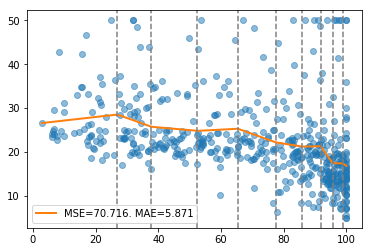

In [11]:
report(x, y, pw, splits)

By default, a continuous piecewise regression is fitted, however, this constraint can be deactivated using ``continuous=False``.

In [12]:
pw = RobustPWRegression(continuous=False)
pw.fit(x, y, splits=splits)

RobustPWRegression(continuous=False, degree=1, h_epsilon=1.35,
                   monotonic_trend=None, objective='l2', quantile=0.5,
                   reg_l1=1.0, reg_l2=1.0, regularization=None, solver='auto',
                   verbose=False)

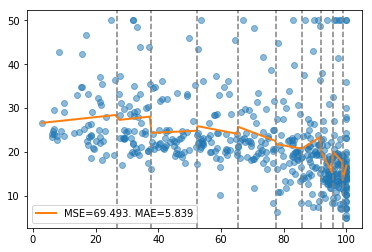

In [13]:
report(x, y, pw, splits)

### Monotonicity

In many applications, it is required to impose certain monotonicity constraints on some features. Four monotonic trends are considered: ascending, descending, convex, concave, peak and valley.

In the following, we minimize the $l_1-$norm with a quadratic function impose descending monotonicity.

In [14]:
pw = RobustPWRegression(objective="l1", degree=2, monotonic_trend="descending")
pw.fit(x, y, splits)

RobustPWRegression(continuous=True, degree=2, h_epsilon=1.35,
                   monotonic_trend='descending', objective='l1', quantile=0.5,
                   reg_l1=1.0, reg_l2=1.0, regularization=None, solver='auto',
                   verbose=False)

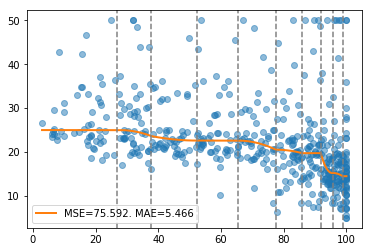

In [15]:
report(x, y, pw, splits)

Similar, using the Huber function as an objective.

In [16]:
pw = RobustPWRegression(objective="huber", degree=2, monotonic_trend="descending")
pw.fit(x, y, splits)

RobustPWRegression(continuous=True, degree=2, h_epsilon=1.35,
                   monotonic_trend='descending', objective='huber',
                   quantile=0.5, reg_l1=1.0, reg_l2=1.0, regularization=None,
                   solver='auto', verbose=False)

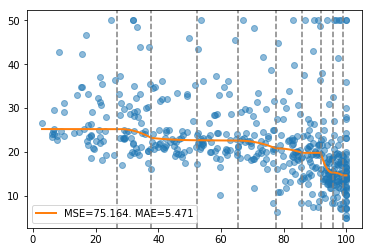

In [17]:
report(x, y, pw, splits)

Now, we select a different variable for testing other basic options. This variable shows a less steady relationship with the target.

In [18]:
variable = "NOX"
x = df[variable].values
y = data.target

In [19]:
est = KBinsDiscretizer(n_bins=10, strategy="quantile")
est.fit(x.reshape(-1, 1), y)
splits = est.bin_edges_[0][1:-1]

In [20]:
pw = RobustPWRegression(objective="l2", degree=1, monotonic_trend=None)
pw.fit(x, y, splits)

RobustPWRegression(continuous=True, degree=1, h_epsilon=1.35,
                   monotonic_trend=None, objective='l2', quantile=0.5,
                   reg_l1=1.0, reg_l2=1.0, regularization=None, solver='auto',
                   verbose=False)

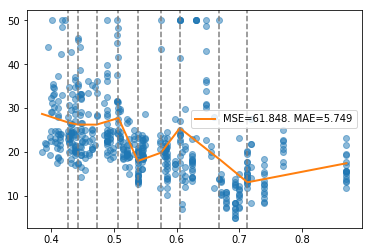

In [21]:
report(x, y, pw, splits)

The relationship with the target exhibits a sort of U-shaped trend. Let's try to force convexity.

In [22]:
pw = RobustPWRegression(objective="l1", degree=1, monotonic_trend="convex")
pw.fit(x, y, splits)

RobustPWRegression(continuous=True, degree=1, h_epsilon=1.35,
                   monotonic_trend='convex', objective='l1', quantile=0.5,
                   reg_l1=1.0, reg_l2=1.0, regularization=None, solver='auto',
                   verbose=False)

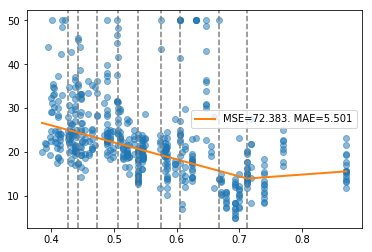

In [23]:
report(x, y, pw, splits)

To reduce the mean squared error (MSE) and mean absolute error (MAE), we replace convex by valley.

In [24]:
pw = RobustPWRegression(objective="l1", degree=1, monotonic_trend="valley")
pw.fit(x, y, splits)

RobustPWRegression(continuous=True, degree=1, h_epsilon=1.35,
                   monotonic_trend='valley', objective='l1', quantile=0.5,
                   reg_l1=1.0, reg_l2=1.0, regularization=None, solver='auto',
                   verbose=False)

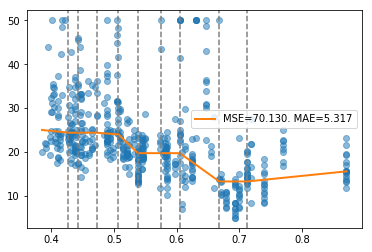

In [25]:
report(x, y, pw, splits)

Note that, for degree >= 2 and convex/concave monotonicity, the monotonicity constraint is only satisfied at each bin individually.

In [26]:
pw = RobustPWRegression(objective="l1", degree=3, monotonic_trend="convex")
pw.fit(x, y, splits)

RobustPWRegression(continuous=True, degree=3, h_epsilon=1.35,
                   monotonic_trend='convex', objective='l1', quantile=0.5,
                   reg_l1=1.0, reg_l2=1.0, regularization=None, solver='auto',
                   verbose=False)

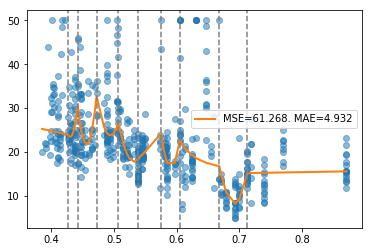

In [27]:
report(x, y, pw, splits)

For those cases, we recommend avoiding splits points and fit a polynomial directly.

In [28]:
pw = RobustPWRegression(objective="l1", degree=3, monotonic_trend="convex")
pw.fit(x, y, splits=[])

RobustPWRegression(continuous=True, degree=3, h_epsilon=1.35,
                   monotonic_trend='convex', objective='l1', quantile=0.5,
                   reg_l1=1.0, reg_l2=1.0, regularization=None, solver='auto',
                   verbose=False)

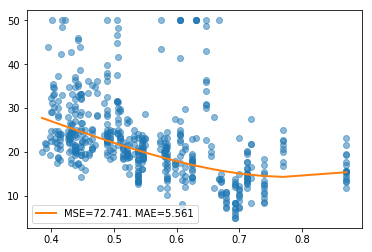

In [29]:
report(x, y, pw, splits=[])

## Advanced

For the advanced section, we load a larger dataset.

In [30]:
data = fetch_california_housing()

df = pd.DataFrame(data.data, columns=data.feature_names)
df["target"] = data.target
x = df["MedInc"].values
y = df["target"].values

In [31]:
est = KBinsDiscretizer(n_bins=15, strategy="quantile")
est.fit(x.reshape(-1, 1), y)
splits = est.bin_edges_[0][1:-1]

If the trend of the relationship with the target is unclear, use the default piecewise regression.

In [32]:
pw = RobustPWRegression()
pw.fit(x, y, splits)

RobustPWRegression(continuous=True, degree=1, h_epsilon=1.35,
                   monotonic_trend=None, objective='l2', quantile=0.5,
                   reg_l1=1.0, reg_l2=1.0, regularization=None, solver='auto',
                   verbose=False)

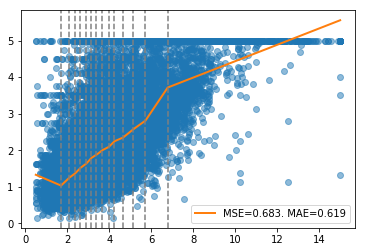

In [33]:
report(x, y, pw, splits)

We observe an ascending monotonic trend. Let's impose ascending monotonicity and show the solver's output.

In [34]:
pw = RobustPWRegression(objective="l2", monotonic_trend="ascending", verbose=True)
pw.fit(x, y, splits)

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 30, constraints m = 44
          nnz(P) + nnz(A) = 116
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -6.0212e+04   2.79e-03   4.32e+04   1.00e-01   1.69e-04s
 150  -1.0169e+05   4.63e-06   1.31e-01   3.16e-04   5.47e-04s
plsh  -1.0169e+05   1.09e-13   2.39e-04   -----

RobustPWRegression(continuous=True, degree=1, h_epsilon=1.35,
                   monotonic_trend='ascending', objective='l2', quantile=0.5,
                   reg_l1=1.0, reg_l2=1.0, regularization=None, solver='auto',
                   verbose=True)

The Quadratic Programming (QP) solver OSQP (``solver="osqp"``) is chosen. The option ``solver="auto"`` selects the most appropriate solver given the user's parameters. We can switch to the ECOS solver using ``solver="ecos"``.

In [35]:
pw = RobustPWRegression(objective="l2", monotonic_trend="ascending", solver="ecos",
                        verbose=True)
pw.fit(x, y, splits)


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+04  5e-01  3e-04  1e+00  4e+02    ---    ---    1  1  - |  -  - 
 1  +1.850e+00  +1.884e+00  +2e+02  1e-02  6e-06  6e-02  7e+00  0.9795  1e-04   3  3  3 |  0  0
 2  +9.096e+01  +9.134e+01  +3e+01  1e-03  5e-07  4e-01  9e-01  0.9522  5e-02   7  8  8 |  0  0
 3  +1.183e+02  +1.183e+02  +9e-01  3e-05  1e-08  1e-02  3e-02  0.9808  1e-04   2  3  3 |  0  0
 4  +1.187e+02  +1.187e+02  +2e-01  8e-06  2e-09  4e-03  6e-03  0.8242  5e-02   2  2  2 |  0  0
 5  +1.188e+02  +1.188e+02  +5e-03  5e-07  7e-11  2e-04  2e-04  0.9789  1e-02   6  5  5 |  0  0
 6  +1.188e+02  +1.188e+02  +4e-04  2e-07  6e-12  1e-05  1e-05  0.9204  3e-03   6  5  5 |  0  0
 7  +1.188e+02  +1.188e+02  +3e-05  1e-07  4e-13  1e-06  1e-06  0.9844  5e-02   1  2  2 |  0  0
 8  +1.188e+02  +1.188e+02  +6e-07  7e-09  4e-

RobustPWRegression(continuous=True, degree=1, h_epsilon=1.35,
                   monotonic_trend='ascending', objective='l2', quantile=0.5,
                   reg_l1=1.0, reg_l2=1.0, regularization=None, solver='ecos',
                   verbose=True)

Note that ECOS is significantly slower for this problem. However, the Second Order Cone Programming (SOCP) solver ECOS is more versatile, handling all the objectives and regularizations options available. Additionally, is better suited for large problems occurring when bounds are imposed.

### Regularization

A regularization term using $l_1-$norm (Lasso) $l_2-$norm (Ridge) can be added to the objective function.

In [36]:
pw = RobustPWRegression(objective="huber", monotonic_trend="ascending",
                        degree=2, regularization="l1", verbose=True)
pw.fit(x, y, splits)


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -6.012e+03  +5e+05  8e-01  5e+00  1e+00  6e+00    ---    ---    2  1  - |  -  - 
 1  +7.934e+02  -3.304e+03  +3e+05  7e-01  3e-01  2e+00  4e+00  0.4820  5e-01   2  1  1 |  0  0
 2  +4.004e+03  +2.932e+03  +1e+05  3e-01  5e-02  8e-01  1e+00  0.7396  1e-01   2  1  1 |  0  0
 3  +6.368e+03  +5.536e+03  +9e+04  2e-01  4e-02  7e-01  1e+00  0.5427  6e-01   1  1  1 |  0  0
 4  +9.067e+03  +8.671e+03  +4e+04  1e-01  2e-02  3e-01  5e-01  0.5371  8e-02   1  2  1 |  0  0
 5  +1.043e+04  +1.022e+04  +2e+04  6e-02  2e-02  2e-01  3e-01  0.6971  4e-01   2  2  2 |  0  0
 6  +1.064e+04  +1.048e+04  +2e+04  5e-02  1e-02  1e-01  2e-01  0.9699  7e-01   2  2  1 |  0  0
 7  +1.216e+04  +1.212e+04  +4e+03  1e-02  7e-03  2e-02  5e-02  0.7909  3e-02   2  2  2 |  0  0
 8  +1.230e+04  +1.227e+04  +3e+03  7e-03  6e-

RobustPWRegression(continuous=True, degree=2, h_epsilon=1.35,
                   monotonic_trend='ascending', objective='huber', quantile=0.5,
                   reg_l1=1.0, reg_l2=1.0, regularization='l1', solver='auto',
                   verbose=True)

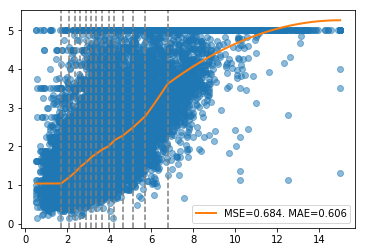

In [37]:
report(x, y, pw, splits)

In [38]:
pw = RobustPWRegression(objective="l2", monotonic_trend="ascending",
                        regularization="l2", verbose=True)
pw.fit(x, y, splits)


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+04  9e-01  3e-04  1e+00  4e+02    ---    ---    1  1  - |  -  - 
 1  +1.166e+00  +1.320e+00  +1e+03  7e-02  3e-05  3e-01  4e+01  0.8967  5e-04   3  3  3 |  0  0
 2  -3.517e+00  -2.508e+00  +9e+02  4e-02  2e-05  1e+00  3e+01  0.2528  1e-01   4  5  5 |  0  0
 3  -1.504e+01  -1.024e+01  +7e+02  1e-02  2e-05  5e+00  2e+01  0.3347  4e-01   5  5  5 |  0  0
 4  +3.145e+01  +3.210e+01  +9e+01  6e-03  2e-06  7e-01  3e+00  0.8796  3e-03   5  5  5 |  0  0
 5  +1.099e+02  +1.101e+02  +1e+01  8e-04  2e-07  2e-01  3e-01  0.9227  3e-02   3  3  3 |  0  0
 6  +1.201e+02  +1.202e+02  +2e+00  1e-04  4e-08  7e-02  5e-02  0.9682  1e-01   2  2  2 |  0  0
 7  +1.212e+02  +1.213e+02  +5e-01  5e-05  1e-08  2e-02  2e-02  0.7164  4e-02   2  2  2 |  0  0
 8  +1.217e+02  +1.217e+02  +1e-01  1e-05  4e-

RobustPWRegression(continuous=True, degree=1, h_epsilon=1.35,
                   monotonic_trend='ascending', objective='l2', quantile=0.5,
                   reg_l1=1.0, reg_l2=1.0, regularization='l2', solver='auto',
                   verbose=True)

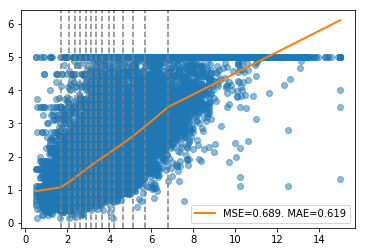

In [39]:
report(x, y, pw, splits)

Increasing the regularization term using parameters ``reg_l1`` and ``reg_l2`` will produce a smoother piecewise
regression.

### Lower and upper bound

In some circumstances, it is required to impose a lower or upper limit to the prediction. For example, if we are predicting house prices, we might need to fix a minimum and maximum price. Parameters ``lb`` and ``ub`` in method ``fit`` impose these constraints.

In [40]:
pw = RobustPWRegression(objective="l2", monotonic_trend="ascending", verbose=True)
pw.fit(x, y, splits, lb=1, ub=5)


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -4.696e+04  +1e+05  2e-01  3e-04  1e+00  2e+00    ---    ---    2  1  - |  -  - 
 1  +1.291e+03  -1.662e+03  +1e+04  2e-02  1e-05  3e-01  3e-01  0.9521  6e-02   4  2  2 |  0  0
 2  +6.676e+02  -8.120e+02  +5e+03  8e-03  5e-06  1e-01  1e-01  0.4951  7e-03   4  4  4 |  0  0
 3  -2.885e+01  -8.321e+02  +3e+03  4e-03  3e-06  3e-02  7e-02  0.9235  5e-01   4  5  5 |  0  0
 4  +9.818e+01  -4.910e+01  +5e+02  7e-04  4e-07  5e-03  1e-02  0.9327  1e-01   3  3  3 |  0  0
 5  +1.012e+02  +3.101e+01  +3e+02  3e-04  2e-07  2e-03  6e-03  0.7438  3e-01   6  7  7 |  0  0
 6  +1.150e+02  +9.573e+01  +7e+01  9e-05  5e-08  6e-04  2e-03  0.9202  2e-01   2  2  2 |  0  0
 7  +1.159e+02  +1.054e+02  +4e+01  5e-05  3e-08  3e-04  9e-04  0.7352  4e-01   4  5  5 |  0  0
 8  +1.186e+02  +1.173e+02  +5e+00  6e-06  3e-

RobustPWRegression(continuous=True, degree=1, h_epsilon=1.35,
                   monotonic_trend='ascending', objective='l2', quantile=0.5,
                   reg_l1=1.0, reg_l2=1.0, regularization=None, solver='auto',
                   verbose=True)

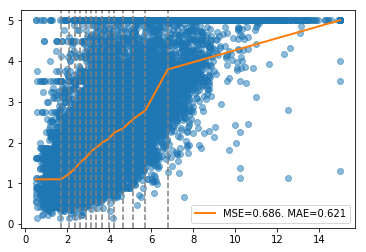

In [41]:
report(x, y, pw, splits)

As previously mentioned, ECOS is more adequate when bounds are active.

In [42]:
pw = RobustPWRegression(objective="l2", solver="osqp", monotonic_trend="ascending",
                        verbose=True)
pw.fit(x, y, splits, lb=1, ub=5)

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 30, constraints m = 41324
          nnz(P) + nnz(A) = 82676
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -7.6198e+01   1.00e+00   5.45e+07   1.00e-01   2.23e-02s
 200  -1.0165e+05   3.97e-03   2.39e+01   2.19e-04   2.19e-01s
 400  -1.0165e+05   8.73e-04   2.06e+01   

RobustPWRegression(continuous=True, degree=1, h_epsilon=1.35,
                   monotonic_trend='ascending', objective='l2', quantile=0.5,
                   reg_l1=1.0, reg_l2=1.0, regularization=None, solver='osqp',
                   verbose=True)